In [1]:
%load_ext autoreload
%autoreload 2

Dependencies

In [2]:
import pathlib as pb

# Environment
ROOT_PATH = pb.Path('..')
DATA_DIR_PATH = ROOT_PATH / 'data'
CACHE_DIR_PATH = ROOT_PATH / '.cache'
TRANSFORMERS_CACHE_DIR_PATH = CACHE_DIR_PATH / 'transformers'
DATASETS_CACHE_DIR_PATH = CACHE_DIR_PATH / 'datasets'
TEST_DATA_FILE = DATA_DIR_PATH / 'test_data.csv'
TRAIN_DATA_FILE = DATA_DIR_PATH / 'train_data.csv'
SUBMISSIONS_DIR_PATH = ROOT_PATH / 'submissions'

# Model Repositories
BERT_RO_MODEL_REPO = 'dumitrescustefan/bert-base-romanian-cased-v1'

In [3]:
import os

os.environ['TRANSFORMERS_CACHE'] = str(TRANSFORMERS_CACHE_DIR_PATH)
os.environ['HF_DATASETS_CACHE'] = str(DATASETS_CACHE_DIR_PATH)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [4]:
from transformers import AutoTokenizer, AutoModel
import torch
import torchdata
import torchtext
from torch import Tensor
from torch import nn
from torch import optim
from torch.utils.data import Subset, DataLoader, Dataset
from torch import backends
import typing
import pathlib as pb
import os
import gc
from typing import List, Tuple, Dict, Set
import random
import numpy as np
import pandas as pd
import platform
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score

/home/invokariman/Projects/git/nitro-lang-processing-2/.cache/pypoetry/virtualenvs/nitro-lang-processing-2-mFR9zZTH-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from utils import get_available_device, read_data
from preprocess import BertPreprocessor
from data import SexismDataset
from models import BertFlatClassModel

Environment Setup

In [6]:
# Use available GPU
DEVICE: torch.device = get_available_device()

# Deterministic experiments
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
np.random.RandomState(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

Dataset & Preprocessing

In [7]:
train_data_raw, test_data_raw = read_data(DATA_DIR_PATH)

In [8]:
train_dataset = SexismDataset(train_data_raw, BertPreprocessor(train_data_raw, BERT_RO_MODEL_REPO))
test_dataset = SexismDataset(test_data_raw, BertPreprocessor(test_data_raw, BERT_RO_MODEL_REPO))

Model Training

In [9]:
# Training specifications
batch_size = 64
num_epochs = 8
num_workers = 1
learning_rate = 1e-5

In [13]:
# Instantiate language model
# Inspired from: https://luv-bansal.medium.com/fine-tuning-bert-for-text-classification-in-pytorch-503d97342db2
model: nn.Module = torch.compile(BertFlatClassModel(BERT_RO_MODEL_REPO, unfreeze='all')).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(weight=train_dataset.weights.to(DEVICE)) # TODO: weighted loss

Some weights of the model checkpoint at dumitrescustefan/bert-base-romanian-cased-v1 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
# Shutup Scikit-Learn Warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

Training

In [15]:
# Inspired from: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for i, (train_idx, valid_idx) in enumerate(kf.split(train_dataset, train_dataset.classes)):
    print('K-FOLD: {}'.format(i))
    
    # Reinitialize the model
    model = torch.compile(BertFlatClassModel(BERT_RO_MODEL_REPO, unfreeze='all')).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Split the data
    train_subset = Subset(train_dataset, train_idx)
    valid_subset = Subset(train_dataset, valid_idx)

    # Create the dataloaders
    train_loader = DataLoader(
        train_subset,
        batch_size,
    )
    valid_loader = DataLoader(
        train_subset,
        batch_size,
    )

    # ---  Training  ---
    for epoch in range(num_epochs):
        model.train()
        epoch_loss: List[float] = []
        epoch_accy: List[float] = []

        for batch_i, batch in enumerate(train_loader):
            # Send batch to GPU
            batch: Dict[str, Tensor] = { k: v.to(DEVICE) for k, v in batch.items() }

            # Make predictions
            y_true: Tensor | np.ndarray = batch['label']
            y_pred: Tensor | np.ndarray = model.forward(batch)

            # Compute the loss
            optimizer.zero_grad()
            loss: Tensor = loss_fn(y_pred, y_true)
            loss.backward()
            optimizer.step()

            # Compute the accuracy
            y_true = y_true.detach().cpu().numpy()
            y_pred = y_pred.detach().argmax(dim=1).cpu().numpy()
            epoch_accy.append(balanced_accuracy_score(y_true, y_pred))

            # Track progress
            epoch_loss.append(loss.detach().cpu().numpy())

        mean_loss: float = np.array(epoch_loss).mean()
        mean_accy: float = np.array(epoch_accy).mean()
        print('Train Epoch {} - Loss: {}, Accuracy: {}'.format(epoch, mean_loss, mean_accy))

        # --- Validation ---
        model.eval()
        with torch.no_grad():
            epoch_loss = []
            epoch_accy = []

            for batch_i, batch in enumerate(valid_loader):
                # Send batch to GPU
                batch: Dict[str, Tensor] = { k: v.to(DEVICE) for k, v in batch.items() }

                # Make predictions
                y_true: Tensor | np.ndarray = batch['label']
                y_pred: Tensor | np.ndarray = model.forward(batch)

                # Compute the loss
                loss: Tensor = loss_fn(y_pred, y_true)

                # Compute the accuracy
                y_true = y_true.detach().cpu().numpy()
                y_pred = y_pred.detach().argmax(dim=1).cpu().numpy()
                epoch_accy.append(balanced_accuracy_score(y_true, y_pred))

                # Track progress
                epoch_loss.append(loss.detach().cpu().numpy())

            mean_loss = np.array(epoch_loss).mean()
            mean_accy = np.array(epoch_accy).mean()
            print('Validation - Loss: {}, Accuracy: {}'.format( mean_loss, mean_accy))

    break

K-FOLD: 0


Some weights of the model checkpoint at dumitrescustefan/bert-base-romanian-cased-v1 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[2023-03-25 21:02:54,669] torch._inductor.utils: [WARNING] using triton random, expect differenc

Train Epoch 0 - Loss: 0.8236340880393982, Accuracy: 0.5925854460215368
Validation - Loss: 0.6184555888175964, Accuracy: 0.7301652245051029
Train Epoch 1 - Loss: 0.5792125463485718, Accuracy: 0.7406907918035898
Validation - Loss: 0.4990919530391693, Accuracy: 0.7914295913379543
Train Epoch 2 - Loss: 0.46445971727371216, Accuracy: 0.7954937590990825
Validation - Loss: 0.3944418132305145, Accuracy: 0.8350237909847436
Train Epoch 3 - Loss: 0.3608465790748596, Accuracy: 0.8470188599841835
Validation - Loss: 0.2783712148666382, Accuracy: 0.8875881041401015
Train Epoch 4 - Loss: 0.2688027620315552, Accuracy: 0.8923356489962017
Validation - Loss: 0.20646992325782776, Accuracy: 0.933977818284816
Train Epoch 5 - Loss: 0.19593022763729095, Accuracy: 0.9317156723163212
Validation - Loss: 0.15547630190849304, Accuracy: 0.9518052754905699
Train Epoch 6 - Loss: 0.14544609189033508, Accuracy: 0.9508910293455075
Validation - Loss: 0.10458528995513916, Accuracy: 0.9715827072781358
Train Epoch 7 - Loss: 

Prediction

In [16]:
model

OptimizedModule(
  (_orig_mod): BertFlatClassModel(
    (bert_model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(50000, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768,

In [17]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
labels: List[str] = []

model.eval()
with torch.no_grad():
    for batch_i, batch in enumerate(test_loader):
        # Send batch to GPU
        batch: Dict[str, Tensor] = { k: v.to(DEVICE) for k, v in batch.items() }

        # Make predictions
        y_pred: Tensor | np.ndarray = model.forward(batch)

        # Compute the accuracy
        y_pred = y_pred.detach().argmax(dim=1).cpu().numpy()
        y_pred = np.vectorize(train_dataset.class_to_label.get)(y_pred)

        # Concatenate the results
        labels.extend(y_pred.tolist())

<Axes: >

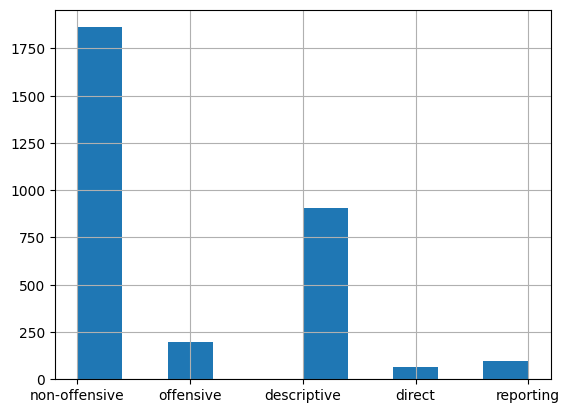

In [18]:
output: pd.DataFrame = pd.DataFrame({ 'Label': pd.Series(data=labels) })
output = output.reset_index()
output = output.rename(columns={ 'index': 'Id' })
output.to_csv(SUBMISSIONS_DIR_PATH / 'submission_5.csv', index=False)
output['Label'].hist()

In [19]:
# Free memory
del model
gc.collect()
torch.cuda.empty_cache()